In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

# Loading the Data

In [24]:
data = pd.read_csv('processed_data/fraud_data_processed.csv', index_col=0)
data.head(2)

,category,amt,gender,lat,long,city_pop,merch_lat,merch_long,is_fraud,customer_age
0,personal_care,2.86,M,33.9659,-80.9355,333497,33.986391,-81.200714,0,52.0
1,personal_care,29.84,F,40.3207,-110.4360,302,39.450498,-109.960431,0,30.0


In [13]:
data.dtypes

category         object
amt             float64
gender           object
lat             float64
long            float64
city_pop          int64
merch_lat       float64
merch_long      float64
is_fraud          int64
customer_age    float64
dtype: object

(array([1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(1, 0, 'amt'),
  Text(2, 0, 'lat'),
  Text(3, 0, 'long'),
  Text(4, 0, 'city_pop'),
  Text(5, 0, 'merch_lat'),
  Text(6, 0, 'merch_long'),
  Text(7, 0, 'is_fraud'),
  Text(8, 0, 'customer_age')])

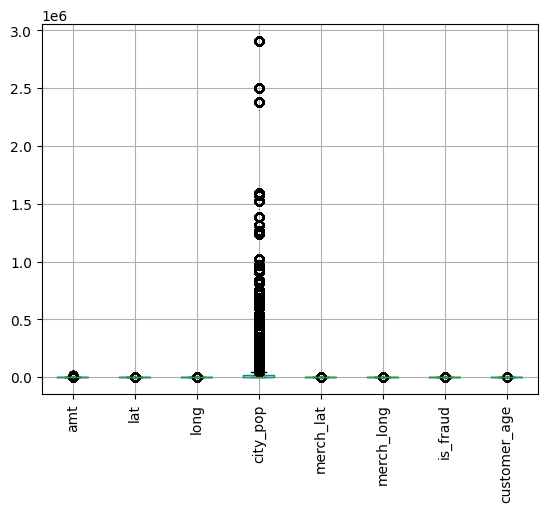

In [14]:
data.boxplot()
plt.xticks(rotation=90)

In [25]:
no_outliers = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'customer_age']

preprocessor = make_column_transformer(
    (RobustScaler(),['city_pop']),
    (MinMaxScaler(), no_outliers),
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=['object'])), remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('robustscaler', RobustScaler(), ['city_pop']),
                                ('minmaxscaler', MinMaxScaler(),
                                 ['amt', 'lat', 'long', 'merch_lat',
                                  'merch_long', 'customer_age']),
                                ('onehotencoder',
                                 OneHotEncoder(sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x2a01f7610>)])

In [33]:
X = data.drop(columns=['is_fraud'])
y = data['is_fraud']
print(X.shape)
print(y.shape)

(555719, 9)
(555719,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(y_train.shape)

(389003, 9)
(389003,)


In [35]:
X_train_processed = preprocessor.fit_transform(X_train)

In [37]:
X_train_processed[0]

array([1.05360698, 0.01235203, 0.52707456, 0.97657948, 0.54171846,
       0.9692015 , 0.58024691, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        ])

In [38]:
X_test_processed = preprocessor.transform(X_test)

In [39]:
print(type(X_train_processed))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [40]:
print(X_train_processed.shape)
print(y_train.shape)

(389003, 23)
(389003,)


In [41]:
X_train_tensor = torch.tensor(X_train_processed).float()
y_train_tensor = torch.tensor(y_train.to_numpy()).float()

# Modeling

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
# X_train_processed = torch.tensor(X_train_processed).float().to(device)
# y_train_processed = torch.tensor(y_train).float().to(device)

In [43]:
class ModelDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.X = x
        self.y = y

    def __getitem__(self, idx):
        features = self.X[idx]
        labels = self.y[idx]
        return features, labels

    def __len__(self):
        return self.X.shape[0]

In [44]:
training_ds = ModelDataset(X_train_tensor, y_train_tensor)

dataloader_train = DataLoader(training_ds, batch_size=32, shuffle=True)

In [45]:
test_ds = ModelDataset(torch.tensor(X_test_processed).float(), torch.tensor(y_test.to_numpy()).float())

dataloader_test = DataLoader(test_ds, batch_size=32, shuffle=True)

In [46]:
feature, labels = next(iter(dataloader_test))
print(f"Features: {feature}, Labels:{labels}")

Features: tensor([[ 2.6742e-01,  3.0057e-02,  4.6460e-01,  8.5883e-01,  4.7965e-01,
          8.4971e-01,  2.0988e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 1.4480e+00,  3.0061e-03,  4.4640e-01,  9.3566e-01,  4.2899e-01,
          9.2732e-01,  1.4815e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.0000e+00],
        [-1.1594e-01,  1.9067e-03,  4.2500e-01,  8.0087e-01,  4.0859e-01,
          7.9984e-01,  4.6914e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
    

In [52]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(23, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 20)
        self.fc4 = nn.Linear(20, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.sigmoid(self.fc4(x))
        return x

In [53]:
model = NeuralNetwork()

In [54]:
model

NeuralNetwork(
  (fc1): Linear(in_features=23, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)

In [55]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [56]:
for epoch in range(100):
    print(f'Working on epoch:{epoch+1}/100')
    for features, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels.view(-1,1))
        loss.backward()
        optimizer.step()

Working on epoch:1/100
Working on epoch:2/100
Working on epoch:3/100
Working on epoch:4/100
Working on epoch:5/100
Working on epoch:6/100
Working on epoch:7/100
Working on epoch:8/100
Working on epoch:9/100
Working on epoch:10/100
Working on epoch:11/100
Working on epoch:12/100
Working on epoch:13/100
Working on epoch:14/100
Working on epoch:15/100
Working on epoch:16/100
Working on epoch:17/100
Working on epoch:18/100
Working on epoch:19/100
Working on epoch:20/100
Working on epoch:21/100
Working on epoch:22/100
Working on epoch:23/100
Working on epoch:24/100
Working on epoch:25/100
Working on epoch:26/100
Working on epoch:27/100
Working on epoch:28/100
Working on epoch:29/100
Working on epoch:30/100
Working on epoch:31/100
Working on epoch:32/100
Working on epoch:33/100
Working on epoch:34/100
Working on epoch:35/100
Working on epoch:36/100
Working on epoch:37/100
Working on epoch:38/100
Working on epoch:39/100
Working on epoch:40/100
Working on epoch:41/100
Working on epoch:42/100
W

In [57]:
from torchmetrics.classification import BinaryRecall

In [69]:
metric = BinaryRecall()
predictions = []
model.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        outputs = model(features)
        pred = (outputs >= 0.5).float()
        predictions.append(pred)
        metric(pred, labels.view(-1,1))

recall = metric.compute()
print(f'Recall: {recall}')

Recall: 0.0


In [70]:
predictions = [pred.numpy() for pred in predictions]

In [71]:
predictions = np.concatenate(predictions).ravel()

In [74]:
pred_ans_df = pd.DataFrame({'Prediction': predictions, 'Actual':y_test})
pred_ans_df

,Prediction,Actual
299345,0.0,0
96950,0.0,0
166710,0.0,0
375822,0.0,0
400247,0.0,0
...,...,...
462364,0.0,0
391582,0.0,0
92875,0.0,0
473656,0.0,0


In [77]:
pred_ans_df[pred_ans_df['Actual']==1]

,Prediction,Actual
479444,0.0,1
327564,0.0,1
158072,0.0,1
354010,0.0,1
336442,0.0,1
...,...,...
58772,0.0,1
15411,0.0,1
295650,0.0,1
5669,0.0,1


In [76]:
pred_ans_df[(pred_ans_df['Prediction'] == 1) & (pred_ans_df['Actual']==1)]

,Prediction,Actual


It looks like this model is unable to idenify any fraudluent transactions.

Let's save the model weights so we can play around the with model more later without retraining.

In [59]:
torch.save(model.state_dict(), 'model_weights/100_epoch_model_weights.pt')

# Balancing Training Dataset
Let's see if balancing the training dataset so that it includes roughly equal numbers of positives and negatives will give us better results.

I will use SMOTE to do the rebalancing.

In [80]:
from imblearn.over_sampling import SMOTE

In [81]:
sm = SMOTE(random_state=42, k_neighbors=5)

In [82]:
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_processed, y_train)

Text(0.5, 1.0, 'Fraud/Non-Fraud Transactions is Reasampled Dataset')

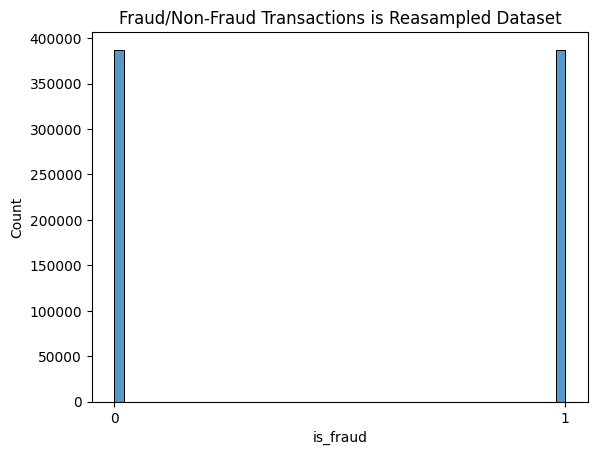

In [85]:
sns.histplot(y_train_resampled)
plt.xticks([0,1])
plt.title('Fraud/Non-Fraud Transactions is Reasampled Dataset')

Now let's retrain a new model using this rebalanced dataset and see if we can get better results.

In [86]:
balanced_training_ds = ModelDataset(torch.tensor(X_train_resampled).float(),
                                    torch.tensor(y_train_resampled).float())

balanced_train_dl = DataLoader(balanced_training_ds, batch_size=32, shuffle=True)

In [87]:
model_balanced = NeuralNetwork()

In [88]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_balanced.parameters(), lr=0.01)

In [89]:
for epoch in range(100):
    print(f'Working on epoch:{epoch+1}/100')
    for features, labels in balanced_train_dl:
        optimizer.zero_grad()
        outputs = model_balanced(features)
        loss = criterion(outputs, labels.view(-1,1))
        loss.backward()
        optimizer.step()

Working on epoch:1/100
Working on epoch:2/100
Working on epoch:3/100
Working on epoch:4/100
Working on epoch:5/100
Working on epoch:6/100
Working on epoch:7/100
Working on epoch:8/100
Working on epoch:9/100
Working on epoch:10/100
Working on epoch:11/100
Working on epoch:12/100
Working on epoch:13/100
Working on epoch:14/100
Working on epoch:15/100
Working on epoch:16/100
Working on epoch:17/100
Working on epoch:18/100
Working on epoch:19/100
Working on epoch:20/100
Working on epoch:21/100
Working on epoch:22/100
Working on epoch:23/100
Working on epoch:24/100
Working on epoch:25/100
Working on epoch:26/100
Working on epoch:27/100
Working on epoch:28/100
Working on epoch:29/100
Working on epoch:30/100
Working on epoch:31/100
Working on epoch:32/100
Working on epoch:33/100
Working on epoch:34/100
Working on epoch:35/100
Working on epoch:36/100
Working on epoch:37/100
Working on epoch:38/100
Working on epoch:39/100
Working on epoch:40/100
Working on epoch:41/100
Working on epoch:42/100
W

In [90]:
metric = BinaryRecall()
predictions = []
model_balanced.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        outputs = model_balanced(features)
        pred = (outputs >= 0.5).float()
        predictions.append(pred)
        metric(pred, labels.view(-1,1))

recall = metric.compute()
print(f'Recall: {recall}')

Recall: 0.7149681448936462


It looks like Recall has improved significantly by rebalancing the training set!

In [91]:
predictions = [pred.numpy() for pred in predictions]
predictions = np.concatenate(predictions).ravel()
balanced_pred_ans_df = pd.DataFrame({'Prediction': predictions, 'Actual':y_test})
balanced_pred_ans_df

,Prediction,Actual
299345,0.0,0
96950,0.0,0
166710,0.0,0
375822,0.0,0
400247,0.0,0
...,...,...
462364,0.0,0
391582,0.0,0
92875,1.0,0
473656,0.0,0


In [94]:
balanced_pred_ans_df[(balanced_pred_ans_df['Prediction']==balanced_pred_ans_df['Actual']) & (balanced_pred_ans_df['Prediction']==1)]

,Prediction,Actual
354010,1.0,1
256888,1.0,1
401795,1.0,1
387605,1.0,1
10193,1.0,1
180683,1.0,1
190806,1.0,1
403272,1.0,1
403254,1.0,1
129480,1.0,1


In [97]:
from sklearn.metrics import precision_score, accuracy_score

In [98]:
accuracy = accuracy_score(predictions, y_test)
precision = precision_score(predictions, y_test)
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')

Recall: 0.7149681448936462
Precision: 0.022292993630573247
Accuracy: 0.9660800403080688


## In conclusion, it seems that rebalancing the dataset offered significant improvement to model performance. Recall increased from 0% to nearly 72%. Accuracy is still very high (~97%) but this is due to the fact that our test set containts very few fraud samples. Precision, or the degree to which our model can correctly classify fraud cases as fraud, is still quite low (~2.3%). There is still a lot of work which needs to be done with this model to improve performance. Perhaps better feature engineering, a more complex model structure, or more training epochs.

Again, let's save the new model's weights so we can use them later if needed.

In [99]:
torch.save(model_balanced.state_dict(), 'model_weights/balanced_model_weights.pt')